In [6]:
# Instalacja wymaganych bibliotek
%pip install scikit-learn shap nltk

import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import shap

# Pobranie leksykonu VADER
nltk.download('vader_lexicon')

# Inicjalizacja VADER
sia = SentimentIntensityAnalyzer()

# Funkcja do analizy sentymentu
def analyze_sentiment(sentence):
    result = sia.polarity_scores(sentence)
    return result['compound'], result['neg'], result['neu'], result['pos']

# Wczytanie danych
df = pd.read_csv('preprocessed.csv')
df = df.dropna(subset=['content'])
df['content'] = df['content'].astype(str)

# Analiza sentymentu dla każdego tweeta
df['compound'], df['negative'], df['neutral'], df['positive'] = zip(*df['content'].apply(analyze_sentiment))

# Funkcja do kategoryzacji sentymentu
def categorize_sentiment(compound):
    if compound >= 0.05:
        return 'positive'
    elif compound <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Dodanie kolumny z kategoriami sentymentu
df['sentiment'] = df['compound'].apply(categorize_sentiment)




[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\JAKUB\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [7]:
# Przygotowanie danych do modelu
X = df[[ 'negative', 'neutral', 'positive', 'compound']]
y = df['sentiment']

# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Trening modelu Random Forest
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predykcje na zbiorze testowym
y_pred = model.predict(X_test)

# Raport klasyfikacji
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00      2087
     neutral       1.00      1.00      1.00      1457
    positive       1.00      1.00      1.00      5107

    accuracy                           1.00      8651
   macro avg       1.00      1.00      1.00      8651
weighted avg       1.00      1.00      1.00      8651



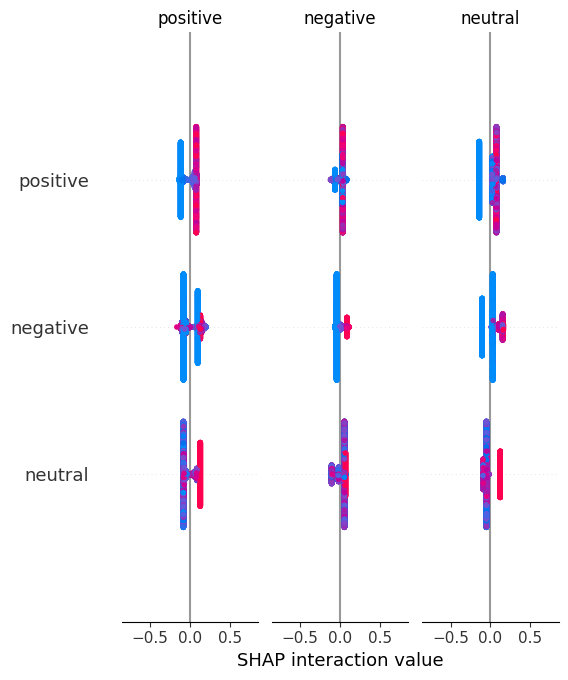

   number          id                                            content  \
0       1  1698308935  sure tune watch donald trump late night david ...   
1       2  1701461182  donald trump appearing view tomorrow morning d...   
2       3  1737479987  donald trump reads top ten financial tips late...   
3       4  1741160716  new blog post celebrity apprentice finale less...   
4       5  1773561338  persona never wallflower rather build walls cl...   

                  date  retweets  favorites  year  month  dayofweek  compound  \
0  2009-05-04 13:54:25       510        917  2009      5          0    0.4767   
1  2009-05-04 20:00:10        34        267  2009      5          0    0.7506   
2  2009-05-08 08:38:08        13         19  2009      5          4    0.5719   
3  2009-05-08 15:40:15        11         26  2009      5          4    0.0000   
4  2009-05-12 09:07:28      1375       1945  2009      5          1    0.0000   

   negative  neutral  positive sentiment  
0       0.0  

In [8]:
# Analiza SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Wizualizacja wartości SHAP dla predykcji
shap.summary_plot(shap_values, X_test)

# Zapisanie wyników do nowego pliku CSV
df['number'] = [i+1 for i, _ in enumerate(df.iterrows())]
df = df[['number'] + list(df.columns[:-1])]
df.to_csv('tweets_sentiment_with_model.csv', index=False)
print(df.head())